In [176]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from scipy.spatial.distance import cdist

# 1. Understand Features and Target Variable

<font color='green'> 
****
Since the data doesnt have header we add them manually   
****
</font>

In [2]:
data_header=['IR','MR','FF','CR','CO','OP','CLASS']
bank_df = pd.read_csv('Qualitative_Bankruptcy.data.txt',names=data_header)
bank_df.head()

,IR,MR,FF,CR,CO,OP,CLASS
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


In [3]:
bank_df.shape

(250, 7)

In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
IR       250 non-null object
MR       250 non-null object
FF       250 non-null object
CR       250 non-null object
CO       250 non-null object
OP       250 non-null object
CLASS    250 non-null object
dtypes: object(7)
memory usage: 13.8+ KB


In [5]:
bank_df.describe()

,IR,MR,FF,CR,CO,OP,CLASS
count,250,250,250,250,250,250,250
unique,3,3,3,3,3,3,2
top,N,N,N,N,N,N,NB
freq,89,119,119,94,103,114,143


<font color='green'> 
****
#### Inference
As the data is in catagorical form we can see top and freq in the Describe output 
    
****
</font>

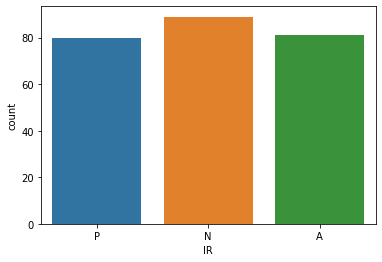

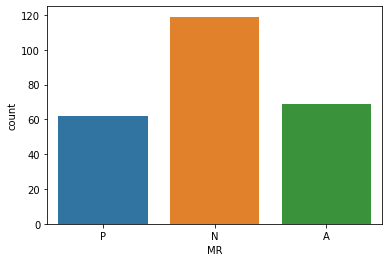

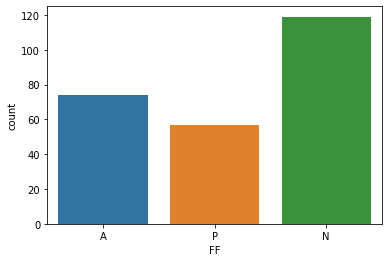

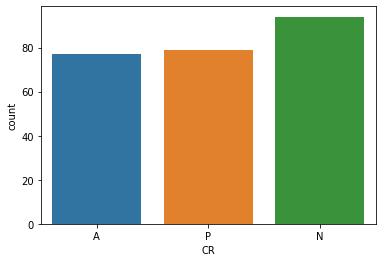

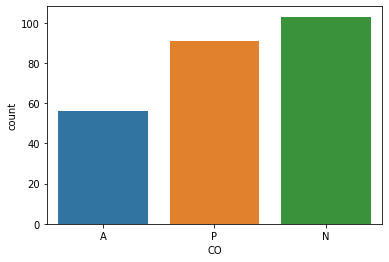

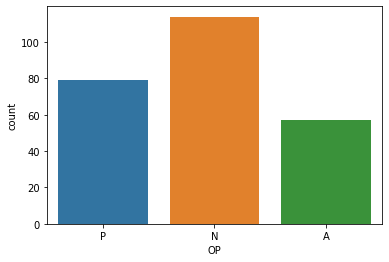

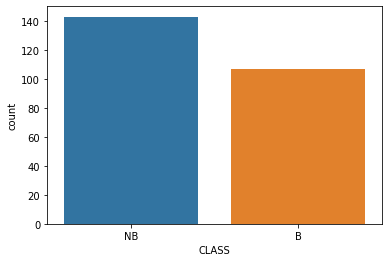

In [6]:
for column in bank_df.columns:
    sns.countplot(bank_df[column])
    plt.show()

<font color='green'> 
****
The above graphs shows that data has no other values than the once expected (P,A,N,NB,B)
****
</font>

In [7]:
sum(bank_df[bank_df.isnull()].count() > 0) 

0

<font color='green'> 
****
Ther are no nulls in the data as we can see from the above check
****
</font>

<font color='green'> 
****
#### Inference
1. There are no null values
2. The target variable **NB** has relatively equal spread of target values.Hence we will not upsample or downsample.
3. All values are valid entries, no invalid entries in data.
4. All the columns are catagorical in nature and hence should be converted to numbers
    
****
</font>

# 2.  Encode independent Variable

<font color='green'> 
****
Since all the independent fileds have P,A,N as the values. Let us encode the values to numeric manually
    so that the encoding is consistant in all the columns.
    
Similarly we will encode the dependent column as well
    
****
</font>

In [8]:
indepedent_var_encoder = {'P':1,'A':2,'N':3}

In [9]:
independent_vars = bank_df.loc[:,bank_df.columns != 'CLASS']
independent_encoded = independent_vars.copy()
for column in independent_vars.columns:
    independent_encoded[column] = independent_vars[column].apply(func=lambda x:indepedent_var_encoder[x])
independent_encoded.head()

,IR,MR,FF,CR,CO,OP
0,1,1,2,2,2,1
1,3,3,2,2,2,3
2,2,2,2,2,2,2
3,1,1,1,1,1,1
4,3,3,1,1,1,3


In [10]:
dependent_var_encoder = {'NB':0,'B':1}

# 3. Encode Seperate Dependent Variable

In [11]:
y=bank_df['CLASS'].apply(func=lambda x:dependent_var_encoder[x])
y.head()

0    0
1    0
2    0
3    0
4    0
Name: CLASS, dtype: int64

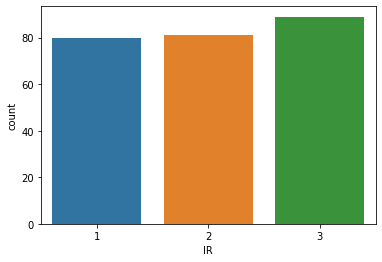

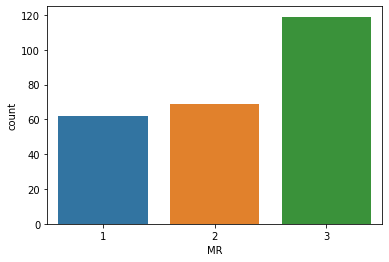

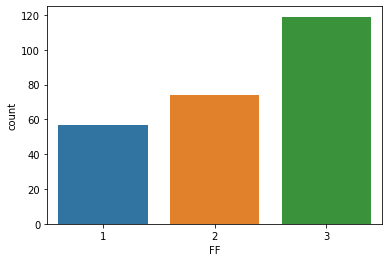

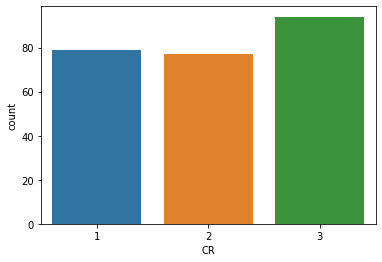

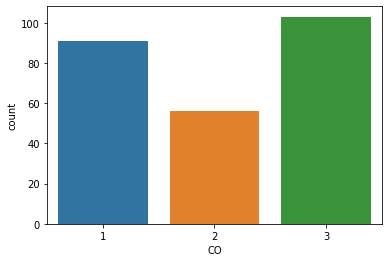

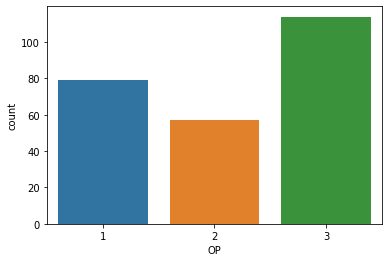

In [12]:
for column in independent_encoded.columns:
    sns.countplot(independent_encoded[column])
    plt.show()

<font color='green'> 
****
The above graphs show that all the values are encoded as expected. As you can see all
the counts are spread over 1,2 and 3
****
</font>

D:\IT\Apps\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\IT\Apps\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


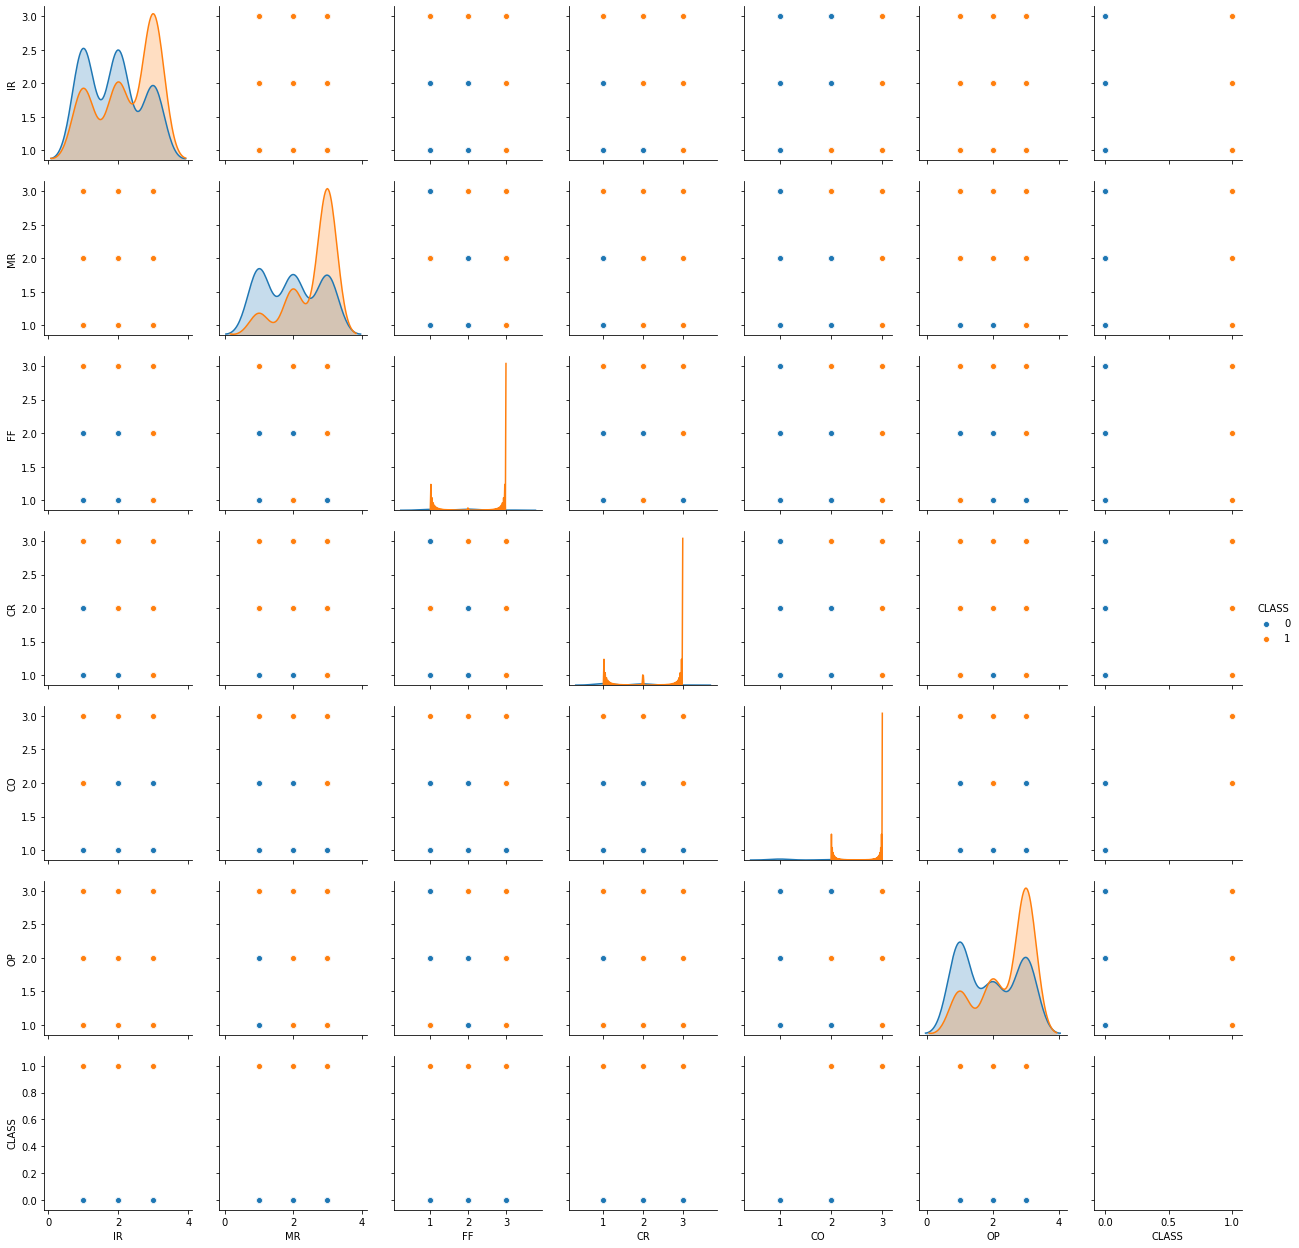

In [13]:
sns.pairplot(independent_encoded.join(y),diag_kind='kde',hue='CLASS')

<font color='green'> 
****
#### Inference
1. As the input shows all the variable are catgorical in nature 
2. The distribubtion of data indicates distinctive clusters     

****
</font>

# 4. Test Train Split

In [14]:
X = independent_encoded
test_size = 0.20
seed=1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size,random_state=seed)

In [15]:
print("Shapes of test and train data")
print("X_train ="+str(X_train.shape))
print("X_test ="+str(X_test.shape))
print("y_train ="+str(y_train.shape))
print("y_test ="+str(y_test.shape))
X.head()

Shapes of test and train data
X_train =(200, 6)
X_test =(50, 6)
y_train =(200,)
y_test =(50,)


,IR,MR,FF,CR,CO,OP
0,1,1,2,2,2,1
1,3,3,2,2,2,3
2,2,2,2,2,2,2
3,1,1,1,1,1,1
4,3,3,1,1,1,3


## Normalizing Train data

In [16]:
X_train_z=X_train.apply(zscore)
X_train_z.head()

,IR,MR,FF,CR,CO,OP
228,-0.080575,-0.292683,0.949894,1.134591,1.071972,1.029125
85,-0.080575,0.926829,0.949894,1.134591,-1.221016,-1.283516
112,1.159034,0.926829,-1.517363,-1.279432,-1.221016,1.029125
148,1.159034,0.926829,0.949894,-0.072421,1.071972,-0.127195
171,-0.080575,-1.512195,0.949894,1.134591,1.071972,1.029125


# 4. Apply PCA on the independent features of train data

#### Using Sklearn library for PCA

In [17]:
pca_model = PCA()
pca_model.fit(X_train_z)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Eigen Values

#### Also called as teh variance along the access
The sum of the variances would be close to 6 as we have used 6 features which are standardized

In [18]:
pca_model.explained_variance_

array([2.63310162, 1.10348142, 0.90979463, 0.74348799, 0.40535645,
       0.23492863])

In [19]:
sum(pca_model.explained_variance_)

6.030150753768844

#### Normalised Variance
This should sum up to 1 as it is normalised

In [20]:
pca_model.explained_variance_ratio_

array([0.43665602, 0.182994  , 0.15087428, 0.12329509, 0.06722161,
       0.038959  ])

In [21]:
sum(pca_model.explained_variance_ratio_)

1.0

#### Eigen Vectors

In [22]:
eigen_vectors=pca_model.components_
eigen_vectors

array([[-0.2659426 , -0.33347355, -0.48174247, -0.48459943, -0.54086354,
        -0.24212421],
       [ 0.59062087,  0.40429833, -0.33348871, -0.27748678, -0.21861727,
         0.50169981],
       [ 0.56170369,  0.07162781,  0.20576748, -0.33298399,  0.11530248,
        -0.71613209],
       [ 0.38014816, -0.83579648,  0.12074163, -0.10097427,  0.16670313,
         0.32305934],
       [-0.25501963,  0.12628462,  0.68920856, -0.59347521, -0.15194525,
         0.26212317],
       [ 0.2353356 , -0.07552579,  0.35324529,  0.46354882, -0.77168722,
        -0.06125443]])

<font color='green'> 
****
Below we will try to find the cummilative variance over each principle component
****
</font>

In [23]:
import itertools 
import operator

cummilatie_variance=list(itertools.accumulate(pca_model.explained_variance_ratio_,operator.add))

cummilatie_variance

[0.4366560189074698,
 0.6196500218851464,
 0.7705242976073249,
 0.8938193900295707,
 0.961041002117166,
 1.0]

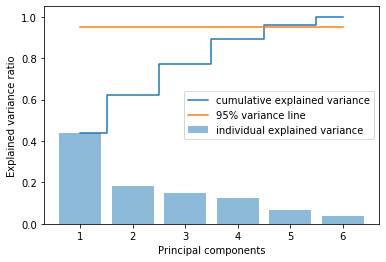

In [27]:
plt.bar(range(1,7), pca_model.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7),cummilatie_variance, where= 'mid', label='cumulative explained variance')
plt.step(range(1,7),np.repeat([0.95],6), where= 'mid', label='95% variance line')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()


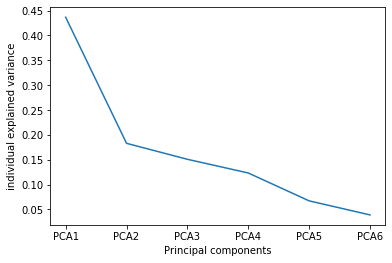

In [33]:
plt.plot(range(1,7), pca_model.explained_variance_ratio_)
plt.ylabel('individual explained variance')
plt.xlabel('Principal components')
plt.xticks([1,2,3,4,5,6],['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']);

<font color='green'> 
****
#### Inference
1. Almost 80% of the variance is captured by the first 3 principle components
    
2. AS the plot shows the 95% line cuts the cummilative variance rations at **Five Principle Components**.

3. As a result we will discard the last Priciple Component and take rest 5 into our models
    
****
</font>

# 7 . Transform Data using Optimum PCA

In [34]:
opt_PCA_model = PCA(n_components=5)
opt_PCA_model.fit(X_train_z)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<font color='green'> 
****

Optimum PCA mode Eigen Value (Variances)
    
****
</font>

In [35]:
opt_PCA_model.explained_variance_

array([2.63310162, 1.10348142, 0.90979463, 0.74348799, 0.40535645])

<font color='green'> 
****

Cummilative Varience Ratio for optimal PCA model   
****
</font>

In [36]:
opt_PCA_model.explained_variance_ratio_

array([0.43665602, 0.182994  , 0.15087428, 0.12329509, 0.06722161])

<font color='green'> 
****

Eigen Vectors for optimal PCA model    
****
</font>

In [37]:
opt_PCA_model.components_

array([[-0.2659426 , -0.33347355, -0.48174247, -0.48459943, -0.54086354,
        -0.24212421],
       [ 0.59062087,  0.40429833, -0.33348871, -0.27748678, -0.21861727,
         0.50169981],
       [ 0.56170369,  0.07162781,  0.20576748, -0.33298399,  0.11530248,
        -0.71613209],
       [ 0.38014816, -0.83579648,  0.12074163, -0.10097427,  0.16670313,
         0.32305934],
       [-0.25501963,  0.12628462,  0.68920856, -0.59347521, -0.15194525,
         0.26212317]])

<font color='green'> 
****

Transforming the data using the PCA model   
****
</font>

In [43]:
X_train_pca = opt_PCA_model.transform(X_train_z)
X_train_pca

array([[-1.71736269e+00, -5.15572629e-01, -8.61955144e-01,
         7.25289972e-01,  7.17866423e-02],
       [-3.23897482e-01, -6.81490572e-01,  6.17165028e-01,
        -1.42334269e+00, -3.19958203e-02],
       [ 1.14490760e+00,  2.70356120e+00, -4.65489077e-02,
        -2.59133838e-01, -9.71501068e-03],
       [-1.58881226e+00,  4.64416713e-01,  1.15168224e+00,
        -7.44221615e-02,  3.22900697e-01],
       [-1.31068762e+00, -1.00861937e+00, -9.49306127e-01,
         1.74455397e+00, -8.22189940e-02],
       [ 1.99832547e+00, -1.65339200e+00, -1.05754739e-01,
         1.16877223e-01, -1.57778320e-01],
       [ 2.55743662e+00, -1.15770470e+00,  1.74513802e-01,
         2.80928234e-01, -4.65878413e-01],
       [ 2.36418344e+00,  7.90322286e-02,  2.17022133e-01,
        -1.94872396e+00,  1.63372117e-02],
       [-3.43004955e-02,  1.95723046e+00, -1.94623815e-01,
        -2.32060663e-01,  1.24180730e-01],
       [ 9.82012487e-01,  1.51919227e-01, -1.50189277e-01,
        -5.75917198e-02

In [46]:
X_train_pca.shape

(200, 5)

# 7. Applying KMeans Algorithm

<font color='green'> 
****

**Note**
Converting all collection to DataFrames to be consistant.

Even though few algorithms are returning numpy arrays we will convert them to Pandas dataframes.

This is for two reasons

1) With Pandas Dataframs we can easily plot sns figures which would make analysis fast and east with less code clutter

2) Pandas data manupulations are more declarative hence better code redaility

****
</font>

In [47]:
X_train_pca_df = pd.DataFrame(X_train_pca)
print(X_train_pca_df.shape)
X_train_pca_df.head()


(200, 5)


,0,1,2,3,4
0,-1.717363,-0.515573,-0.861955,0.725290,0.071787
1,-0.323897,-0.681491,0.617165,-1.423343,-0.031996
2,1.144908,2.703561,-0.046549,-0.259134,-0.009715
3,-1.588812,0.464417,1.151682,-0.074422,0.322901
4,-1.310688,-1.008619,-0.949306,1.744554,-0.082219


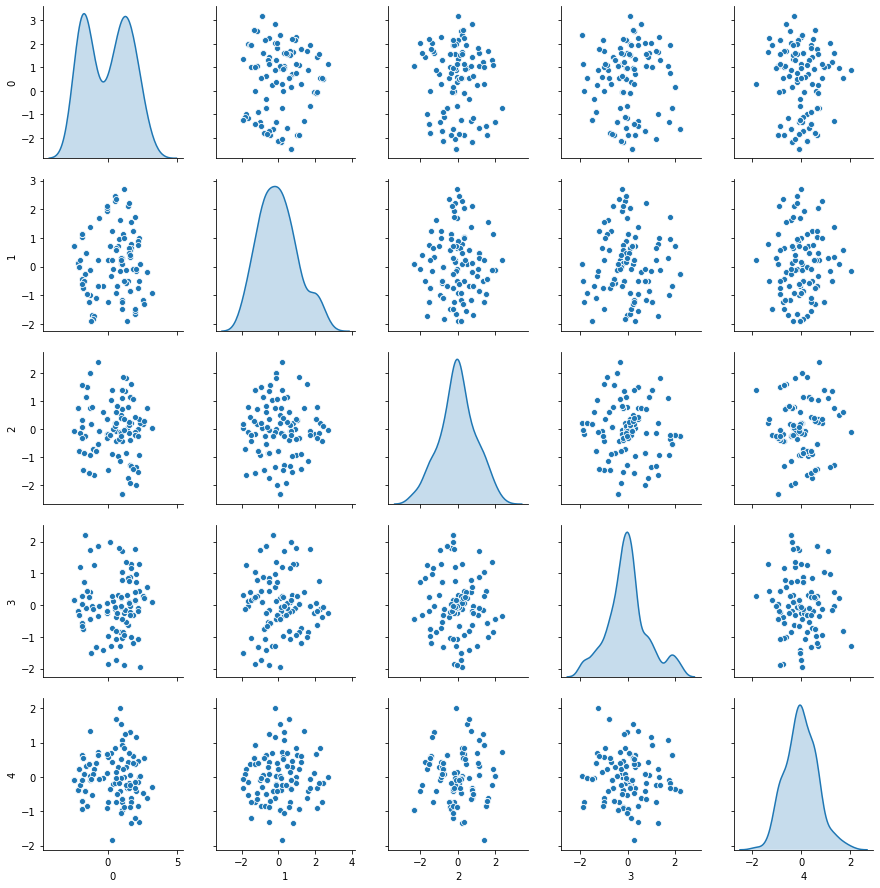

In [49]:
sns.pairplot(X_train_pca_df,diag_kind='kde')

<font color='green'> 
****
#### Inference
1. As the pair plot show the distribution now is not linear this shows how PCA hasderived projections that are linearly independent of each other with out loosing variance from the data.

2. The diagonal indicates that there are a minimumm of 2 clusters.In fact the 3rd dimenssion has around 5 clusters visible.


****
</font>

# 8. Selecting and Apply optimal Kmeans Model

In [68]:
mean_error = []
inertia = []
n_tries = range(1,10)

for i in n_tries:
    model = KMeans(n_clusters=i)
    model.fit(X_train_pca_df)
    inertia.append(model.inertia_)
    mean_error.append(sum(np.min(cdist(X_train_pca_df, model.cluster_centers_, 'euclidean'), axis=1)))

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

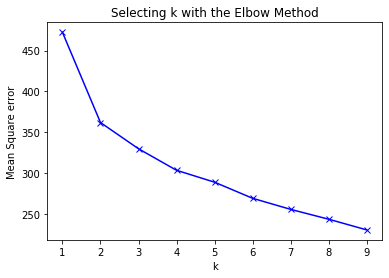

In [69]:
plt.plot(n_tries, mean_error, 'bx-')
plt.xlabel('k')
plt.ylabel('Mean Square error')
plt.title('Selecting k with the Elbow Method')

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

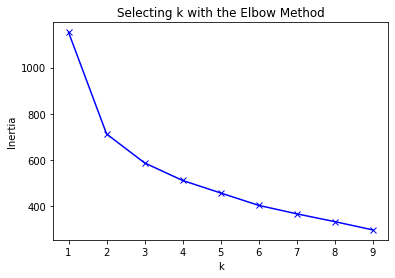

In [71]:
plt.plot(n_tries, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Selecting k with the Elbow Method')

<font color='green'> 
****
#### Inference
1. The drop is very drastical betweeb 1 to 3 and after which the drop has become constant.
2. Hence choosing 3 as the number of clusters for this data set
3. Both the sum of square and errors and inertia represent the same notion of error.Inface you can see then are linearly dependent :) which means one of them is redundant.


****
</font>

# 9 . Select optimal number of clusters and form clusters out of the train data

<font color='green'> 
****
Applying the number of clusters to be 3 as inferred above

****
</font>

In [109]:
opt_kmean_model = KMeans(n_clusters=3)
opt_kmean_model.fit(X_train_pca_df)
clusters_predicted = opt_kmean_model.predict(X_train_pca_df)

clusters_predicted

array([0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 0, 1, 2,
       2, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 1, 0,
       1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 0, 0, 2,
       1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 0, 2, 0, 2, 0,
       2, 0, 1, 0, 1, 0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       2, 0, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 2, 1, 1,
       0, 2])

In [114]:
np.bincount(clusters_predicted)

array([86, 48, 66], dtype=int64)

In [115]:
clusters_predicted_df=pd.DataFrame(clusters_predicted)
clusters_predicted_df.head()

,0
0,0
1,0
2,2
3,0
4,0


In [130]:
clusters_predicted_df.shape

(200, 1)

<font color='green'> 
****
Above operation are to inspect and verify that tranformation from np array to pd dataframe didnt change the order or count.
As we see it is the same. There was no change
****
</font>

# 10. Create a new column in the train data and populate it with the cluster labels. 

In [134]:
X_train_pca_kmean =  pd.concat([X_train_pca_df,clusters_predicted_df],axis=1,)
X_train_pca_kmean.head()

,0,1,2,3,4,0
0,-1.717363,-0.515573,-0.861955,0.725290,0.071787,0
1,-0.323897,-0.681491,0.617165,-1.423343,-0.031996,0
2,1.144908,2.703561,-0.046549,-0.259134,-0.009715,2
3,-1.588812,0.464417,1.151682,-0.074422,0.322901,0
4,-1.310688,-1.008619,-0.949306,1.744554,-0.082219,0


In [138]:
X_train_pca_kmean.columns=['0','1','2','3','4','5']

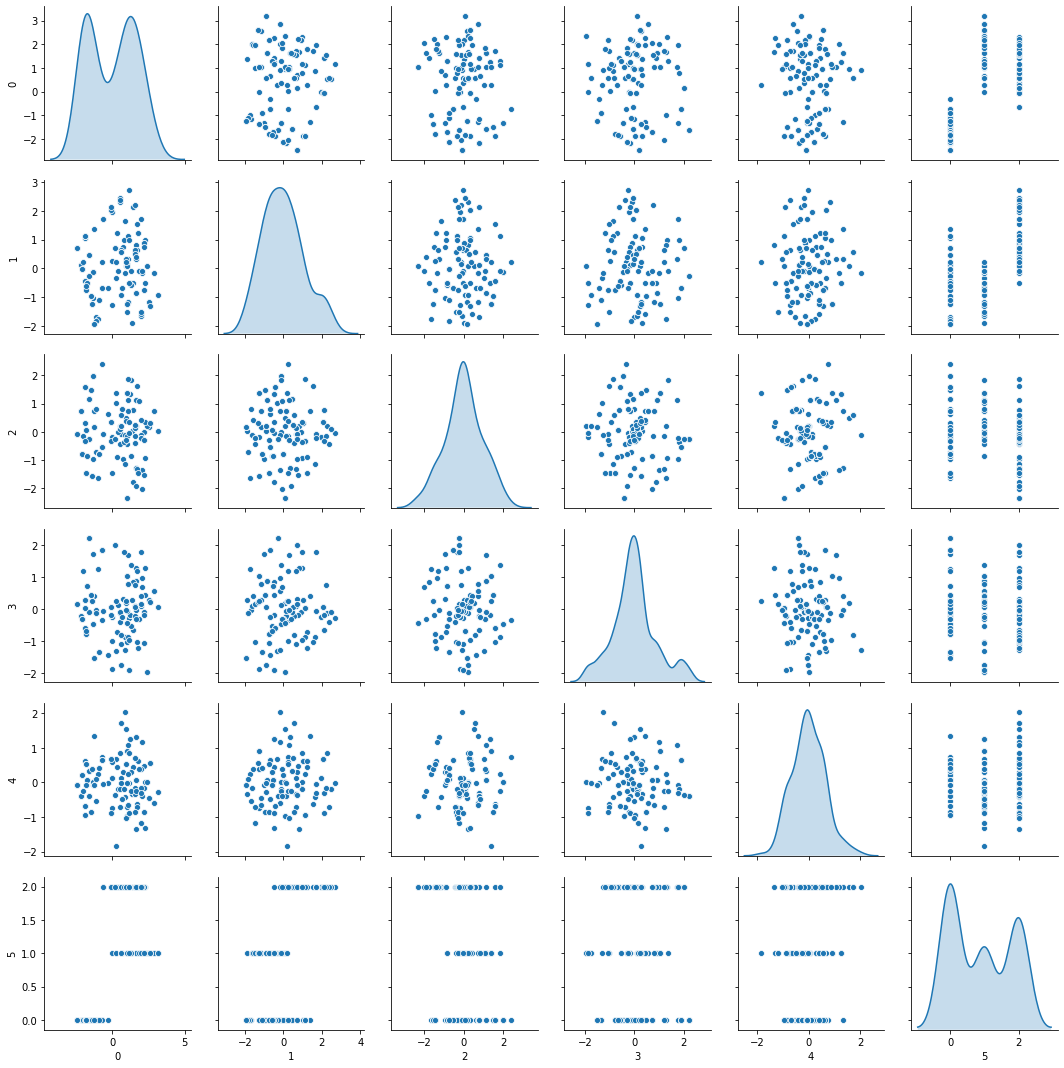

In [140]:
sns.pairplot(X_train_pca_kmean,diag_kind='kde')

# 11. Transform Test Data

### Normalize Test data

<font color='green'> 
    
****
    We will now replicate the same procedure to test data
    1)normalize
    2)Apply same PCA model
    3)Apply Kmean model we defined earlier
****
</font>

In [141]:
X_test_z=X_test.apply(zscore)
print(X_test_z.shape)
X_test_z.head()

(50, 6)


,IR,MR,FF,CR,CO,OP
67,-1.059784,-0.220300,0.894737,-0.071899,-1.082493,0.853115
249,-1.059784,1.003589,0.894737,1.126415,0.022092,-0.299743
230,0.092155,-1.444188,0.894737,1.126415,1.126676,0.853115
161,0.092155,1.003589,0.894737,1.126415,1.126676,0.853115
91,-1.059784,-0.220300,-0.421053,-1.270213,-1.082493,-1.452600


In [142]:
X_test_pca = opt_PCA_model.transform(X_test_z)
X_test_pca

array([[ 0.33803666, -0.32877207, -1.13877211, -0.00830551,  1.28987646],
       [-0.96909494, -0.98634196, -0.49716747, -1.34052968,  0.26323807],
       [-1.33574008, -0.95870766, -0.7236847 ,  1.6998003 , -0.20529136],
       [-2.15200893,  0.03092444, -0.54835582, -0.34604303,  0.10382522],
       [ 2.11087998, -0.71423159,  0.64069697, -0.79105992,  0.48981143],
       [-1.4375248 , -1.14425095, -1.28306876,  0.23897107,  0.24303403],
       [ 0.99330863,  0.29125846,  1.292278  ,  1.6389888 ,  0.95676295],
       [-2.05022422,  0.21646772,  0.01102824,  1.1147862 , -0.34450017],
       [-2.45835864,  0.71128378,  0.09869268,  0.09186454, -0.18994188],
       [ 1.16564842,  2.73688079,  0.10051532, -0.35215429, -0.24563656],
       [-2.17922395,  0.13289541,  0.92429089, -0.28057682, -0.49213253],
       [-1.84565922, -0.64943489, -1.19540431, -0.78395059,  0.39759232],
       [ 1.92158482, -1.45052894,  0.68039389,  0.41599947,  0.16741674],
       [-1.29695411,  1.37631633,  0.8

In [148]:
X_test_pca.shape

(50, 5)

In [155]:
X_test_pca_df = pd.DataFrame(X_test_pca)
print(X_test_pca_df.shape)
X_test_pca_df.head()

(50, 5)


,0,1,2,3,4
0,0.338037,-0.328772,-1.138772,-0.008306,1.289876
1,-0.969095,-0.986342,-0.497167,-1.340530,0.263238
2,-1.335740,-0.958708,-0.723685,1.699800,-0.205291
3,-2.152009,0.030924,-0.548356,-0.346043,0.103825
4,2.110880,-0.714232,0.640697,-0.791060,0.489811


# 12. Use the same kmeans object, assign cluster labels to the test data and store it as a feature.

In [156]:
clusters_predicted_test = opt_kmean_model.predict(X_test_pca_df)

In [157]:
clusters_predicted_test

array([2, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 2, 0, 2,
       2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 2, 2, 0, 0, 2, 1, 2,
       1, 2, 2, 1, 2, 1])

In [158]:
np.bincount(clusters_predicted_test)

array([21, 13, 16], dtype=int64)

In [161]:
clusters_predicted_test_df=pd.DataFrame(clusters_predicted_test)
clusters_predicted_test_df.head()

,0
0,2
1,0
2,0
3,0
4,1


In [162]:
clusters_predicted_test_df.shape

(50, 1)

In [164]:
X_test_pca_kmean =  pd.concat([X_test_pca_df,clusters_predicted_test_df],axis=1,)
X_test_pca_kmean.head()

,0,1,2,3,4,0
0,0.338037,-0.328772,-1.138772,-0.008306,1.289876,2
1,-0.969095,-0.986342,-0.497167,-1.340530,0.263238,0
2,-1.335740,-0.958708,-0.723685,1.699800,-0.205291,0
3,-2.152009,0.030924,-0.548356,-0.346043,0.103825,0
4,2.110880,-0.714232,0.640697,-0.791060,0.489811,1


In [165]:
X_test_pca_kmean.shape

(50, 6)

<font color='green'> 
****
There is a duplicate in column names .
   This will not work when we perform a sns pairplot or any other application that is sensitive to duplicate column names.
    Hence renaming the fields to have disinct field names
   
****
</font>

In [166]:
X_test_pca_kmean.columns=['0','1','2','3','4','5']
X_test_pca_kmean.head()

,0,1,2,3,4,5
0,0.338037,-0.328772,-1.138772,-0.008306,1.289876,2
1,-0.969095,-0.986342,-0.497167,-1.340530,0.263238,0
2,-1.335740,-0.958708,-0.723685,1.699800,-0.205291,0
3,-2.152009,0.030924,-0.548356,-0.346043,0.103825,0
4,2.110880,-0.714232,0.640697,-0.791060,0.489811,1


In [167]:
print("Shapes of test and train data")
print("X_train ="+str(X_train_pca_kmean.shape))
print("X_test ="+str(X_test_pca_kmean.shape))
print("y_train ="+str(y_train.shape))
print("y_test ="+str(y_test.shape))

Shapes of test and train data
X_train =(200, 6)
X_test =(50, 6)
y_train =(200,)
y_test =(50,)


# 13. Apply Classification

In [171]:
svc_cls=SVC()
svc_cls.fit(X_train_pca_kmean, y_train)

D:\IT\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [172]:
svc_cls.score(X_test_pca_kmean,y_test)

1.0

In [173]:
y_predict = svc_cls.predict(X_test_pca_kmean)

In [174]:
y_predict

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [178]:
y_test

67     0
249    1
230    1
161    1
91     0
224    1
58     0
234    1
180    1
4      0
242    1
188    1
116    0
182    1
127    0
78     0
184    1
51     0
27     0
73     0
225    1
34     0
95     0
186    1
120    0
119    0
246    1
239    1
38     0
216    1
226    1
44     0
62     0
208    1
160    1
229    1
39     0
31     0
18     0
236    1
205    1
19     0
93     0
102    0
33     0
110    0
35     0
11     0
29     0
0      0
Name: CLASS, dtype: int64

<font color='green'> 
****
The above we are trying to manually inspect if the accuray score reflects the predicted values and it does all the predicted values exactly match with the actual values
   
****
</font>

# 14. Check Accuracy and Confusion Matrix

In [177]:
print("Accuracy Score = "+ str(svc_cls.score(X_test_pca_kmean,y_test)))
print("Recall Score = "+str(metrics.recall_score(y_test,y_predict)))
print("Classification Report")
print(metrics.classification_report(y_test,y_predict))

Accuracy Score = 1.0
Recall Score = 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



<font color='green'> 
****
#### Inference

1. As we can see from the classificaiton report that we were able to predict all the values spot on. But however this is  because the data is perfectly catagorical.

2. The data initially provided in itself was catagorical(P,A,N). As we converted this into a numbers and then used PCA for dimenssionality reduction . we were able to filter out the noise.

3. The clustering added additional dimension to the data which would aid SVC.

4. **SVC** workes best in this case as we made all the dimessions linearlly independent of each other. In other words we made the data **linearly seperable**. Hence SVC was able to find the perfect hype place that could classify our data.  

The data in this case is very catagorical that a plane LogesticRegression would also have given comparable results

****
</font>